# Outlier identification
This tutorial demonstrates the application of the hierarchical Bayesian model to identify contaminated data points (outliers) in impedance spectra and robustly recover the DRT when outliers are present.

In [1]:
import numpy as np
import pandas as pd
import os
import sys
import time
import matplotlib.pyplot as plt
%matplotlib notebook
from copy import deepcopy

from bayes_drt.inversion import Inverter
from bayes_drt.stan_models import save_pickle,load_pickle
from bayes_drt import eis_utils as gt

%load_ext autoreload
%autoreload 2

# 1. Load experimental data

For this example, we use experimental data obtained from a protonic ceramic microelectrode.

In [3]:
datadir = '../data'

tick_size = 9
label_size = 11

plt.rcParams['font.family'] = 'serif'
plt.rcParams["mathtext.fontset"] = "dejavuserif"
plt.rcParams['xtick.labelsize'] = tick_size
plt.rcParams['ytick.labelsize'] = tick_size
plt.rcParams['axes.labelsize'] = label_size
plt.rcParams['legend.fontsize'] = tick_size - 1

In [4]:
# load experimental data
Zdf = gt.read_eis_zdata(os.path.join(datadir,'experimental','PDAC_COM3_02109_Contact10_2065C_500C.txt'))
# make complex impedance array
Z = Zdf['Zreal'].values + 1j*Zdf['Zimag'].values
# get frequency vector for convenience
freq = Zdf['Freq'].values

<IPython.core.display.Javascript object>


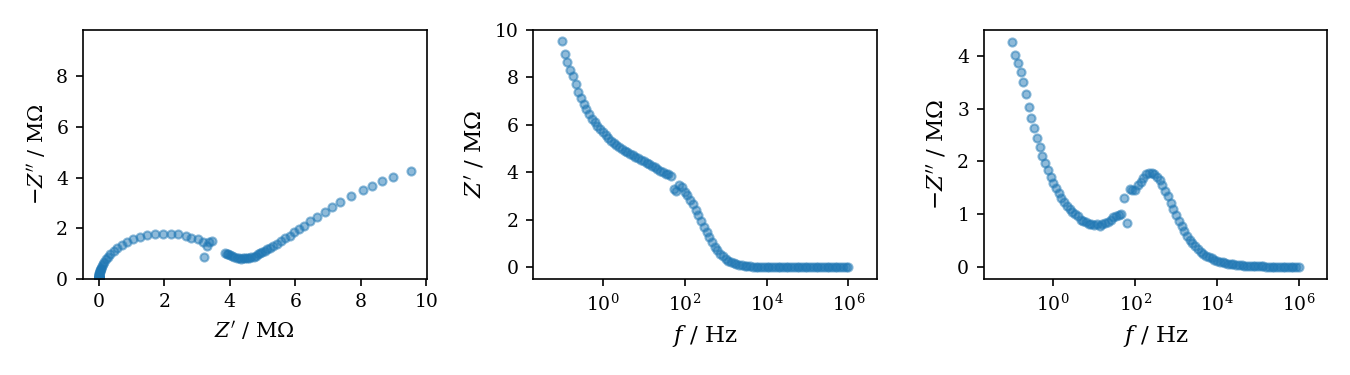

In [6]:
# plot the impedance data
axes = gt.plot_full_eis(Zdf,bode_cols=['Zreal','Zimag'],s=15,alpha=0.5)

The Nyquist and Bode plots reveal several contaminated data points near $f\approx 10^2 \mathrm{Hz}$.
# 2. Fit the data
Since the low-frequency arc is truncated, we need to use an expanded basis frequency range. From the Bode plots, we can estimate that the low-frequency arc may end near $10^{-3}$ Hz. Since there are clearly corrupted data points, we run `bayes_fit` and `map_fit` with the argument `outliers=True` to enable outlier detection.

In [9]:
"HMC sampling"
# Create an Inverter instance with expanded basis_freq,
# making sure to use 10 ppd spacing for basis frequencies
inv_hmc = Inverter(basis_freq=np.logspace(6,-3,91))

# Fit with outlier detection
start = time.time()
inv_hmc.bayes_fit(freq,Z,outliers=True)
elapsed = time.time() - start
print('HMC fit time: {:.2f} s'.format(elapsed))

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


HMC fit time: 161.48 s


In [10]:
"MAP optimization"
# Create an Inverter instance with expanded basis_freq,
# making sure to use 10 ppd spacing for basis frequencies
inv_map = Inverter(basis_freq=np.logspace(6,-3,91))

# Fit with outlier detection
start = time.time()
inv_map.map_fit(freq,Z,outliers=True)
elapsed = time.time() - start
print('HMC fit time: {:.2f} s'.format(elapsed))

HMC fit time: 25.28 s


Fit times tend to be longer when outlier detection is enabled due to the increased number of model parameters.

# 3. Visualize results

With the fits complete, we examine the results for `bayes_fit` and `map_fit`.

In [37]:
# Define convenience functions for plotting results

def plot_drt_result(inv,Zdf,plot_ci=False,tau_plot=np.logspace(-6,2,200)):
    fig, axes = plt.subplots(2,2,figsize=(7.5,6))
    freq = Zdf['Freq'].values
    unit_scale = gt.get_unit_scale(Zdf)
    scale_factor = gt.get_scale_factor(Zdf)
    
    # plot noisy data
    gt.plot_full_eis(Zdf,axes=axes.ravel()[:3],alpha=0.4,label='Data',bode_cols=['Zreal','Zimag'],s=20)
    # get fitted impedance from DRT instance
    Z_pred = inv.predict_Z(freq)
    df_pred = gt.construct_eis_df(freq,Z_pred)
    # plot impedance fit
    gt.plot_full_eis(df_pred,axes=axes.ravel()[:3],alpha=0.8,label='Fit',bode_cols=['Zreal','Zimag'],
                     c='k',plot_func='plot')

    # get the recovered DRT    
    g_pred = inv.predict_distribution('DRT',tau_plot)
    # scale to Mohms
    g_pred /= scale_factor
    # plot the recovered DRT
    if plot_ci:
        # plot mean and 95% credibility interval (CI) if MCMC sampling used
        g_lo = inv.predict_distribution('DRT',tau_plot,percentile=2.5)/scale_factor
        g_hi = inv.predict_distribution('DRT',tau_plot,percentile=97.5)/scale_factor
        axes[1,1].plot(tau_plot,g_pred,c='k',label='Posterior mean',alpha=0.8)
        axes[1,1].fill_between(tau_plot,g_lo,g_hi,color='k',label='95% CI',alpha=0.15)
    else:
        # otherwise plot point estimate only
        axes[1,1].plot(tau_plot,g_pred,c='k',label='Recovered',alpha=0.8)
        
    # mark measurement boundaries in DRT plot
    axes[1,1].axvline(1/(2*np.pi*Zdf['Freq'].min()),ls=':',c='gray',label='Data limit')
#     axes[1,1].axvline(1/(2*np.pi*Zdf['Freq'].max()),ls=':',c='k',lw=1)
    
    axes[1,1].set_xscale('log')
    axes[1,1].set_xlabel(r'$\tau$ / s')
    axes[1,1].set_ylabel('$\gamma \ / \ \mathrm{M}\Omega$')

    for ax in axes.ravel():
        ax.legend()
        
    for ax in [axes[0,0],axes[1,0],axes[1,1]]:
        ax.axhline(0,c='k',lw=0.5)

    fig.tight_layout()

def plot_resid(inv,Zdf):
    fig,axes = plt.subplots(1,2,figsize=(7.5,3),sharex=True)
    freq = Zdf['Freq'].values
    Z = Zdf['Zreal'].values + 1j*Zdf['Zimag'].values
    
    # plot residuals
    Z_pred = inv.predict_Z(freq)
    df_err = gt.construct_eis_df(freq,Z_pred-Z)
    scale_factor = gt.get_scale_factor(df_err)
    gt.plot_bode(df_err,axes=axes,cols=['Zreal','Zimag'],alpha=0.4,s=20,label='Residuals')

    # get the recovered error scale
    sigma_re, sigma_im = inv.predict_sigma(freq)
    sigma_re /= scale_factor
    sigma_im /= scale_factor
    # plot recovered error scale
    axes[0].fill_between(freq,-3*sigma_re,3*sigma_re,color='k',alpha=0.15,label='Recovered $\pm3\sigma$')
    axes[1].fill_between(freq,-3*sigma_im,3*sigma_im,color='k',alpha=0.15)

    axes[0].legend()
    
    for ax in axes:
        ax.axhline(0,c='k',lw=0.5)
    
    fig.tight_layout()

<IPython.core.display.Javascript object>


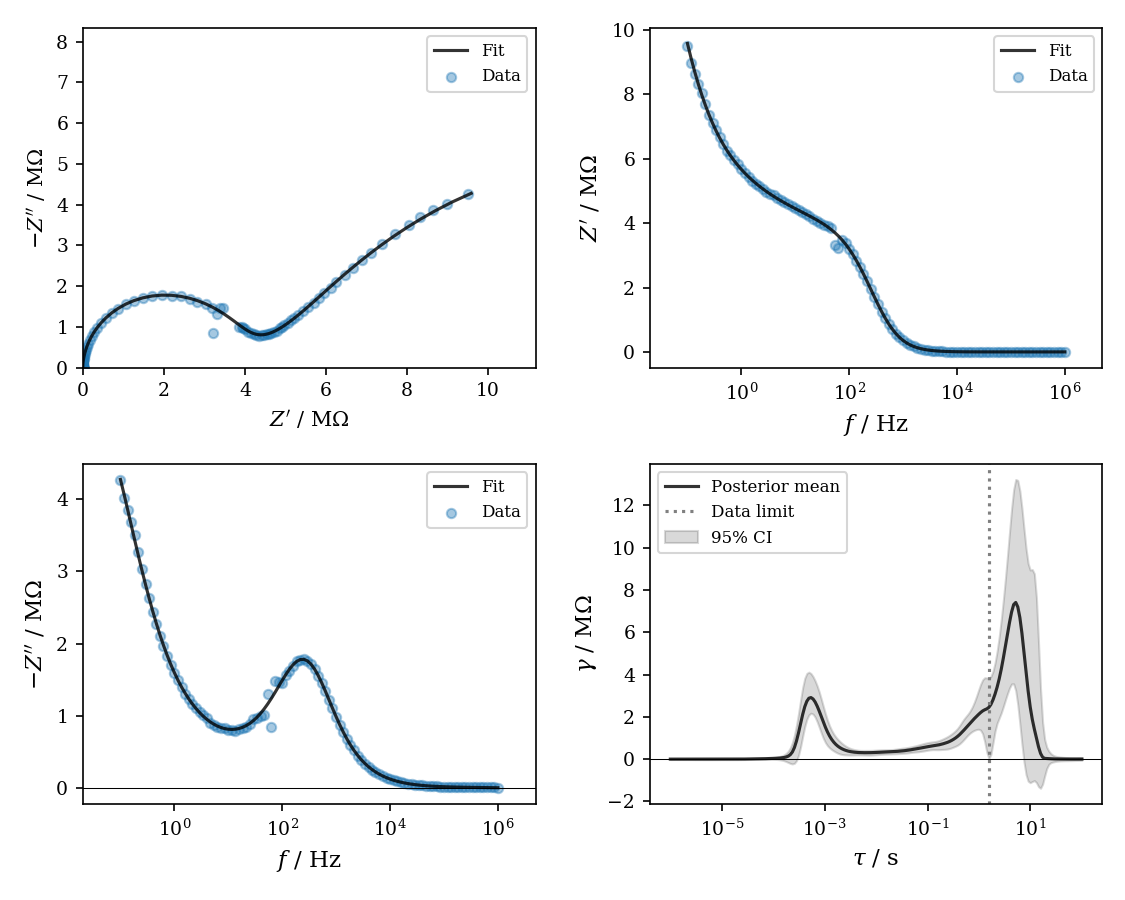

In [38]:
plot_drt_result(inv_hmc,Zdf,plot_ci=True)

<IPython.core.display.Javascript object>


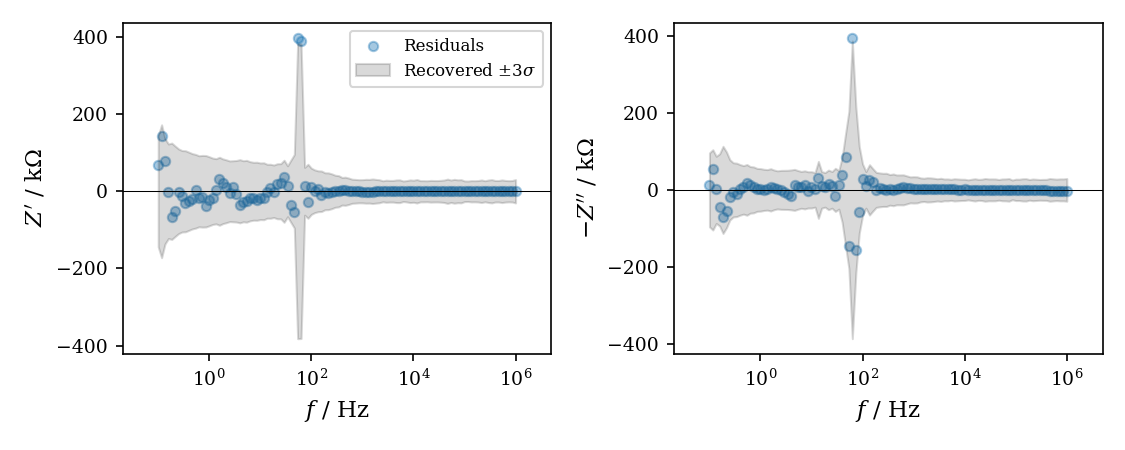

In [19]:
plot_resid(inv_hmc,Zdf)

The HMC fit indicates two features in the DRT: a symmetric peak at $\tau \approx 10^{-3}$ s and an asymmetric peak near $\tau \approx 10^1$ s with a long tail on the left side. The shape of the long-timescale feature is reminiscent of the Gerischer DRT, suggesting that it may represent a diffusion-limited process. The CI widens at frequencies below the lowest measured frequency, indicating higher uncertainty in the extrapolated DRT.

The residual plots and recovered error scale illustrate the outlier detection method. When the fit is performed with `outliers=True`, an independent point-by-point outlier contribution is added to the model error scale, which allows the model to increase the local error scale as necessary to account for contaminated data points without inflating the global error scale. The spikes in the recovered error scale near $f\approx 10^2 \ \mathrm{Hz}$ indicate the points that the model effectively "flagged" as outliers.

We can more directly check which data points were flagged as outliers by examining the outlier error contribution, `sigma_out`, on its own. For HMC sampling results, this parameter can be found in the `_sample_result` attribute.

<IPython.core.display.Javascript object>


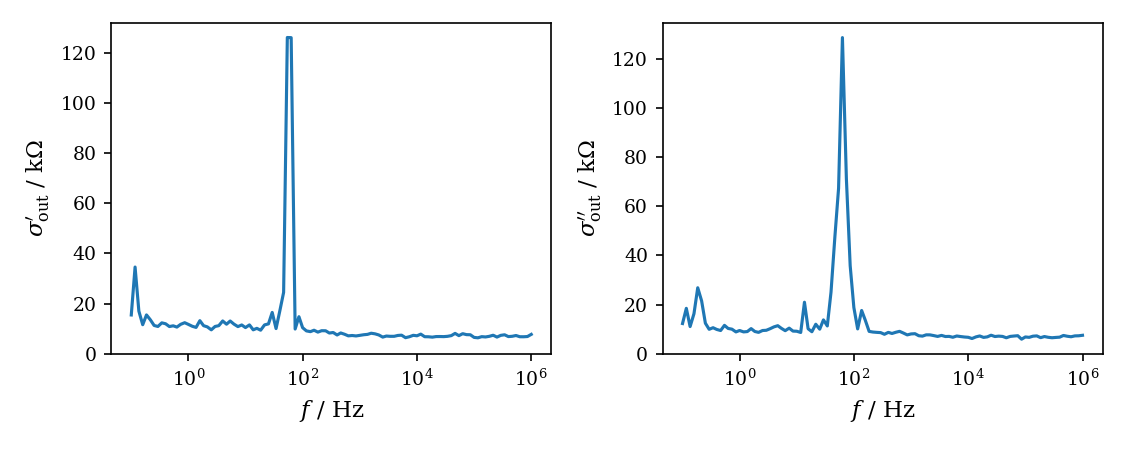

In [24]:
fig,axes = plt.subplots(1,2,figsize=(7.5,3),sharex=True)

# get sigma_out
sigma_out = np.mean(inv_hmc._sample_result['sigma_out'],axis=0)
sigma_re = sigma_out[:len(freq)]*inv_hmc._Z_scale
sigma_im = sigma_out[len(freq):]*inv_hmc._Z_scale

axes[0].plot(freq,sigma_re/1e3)
axes[1].plot(freq,sigma_im/1e3)

for ax in axes:
    ax.set_xscale('log')
    ax.set_xlabel('$f$ / Hz')
    
axes[0].set_ylabel('$\sigma_{\mathrm{out}}^\prime$ / k$\Omega$')
axes[1].set_ylabel('$\sigma_{\mathrm{out}}^{\prime\prime}$ / k$\Omega$')

for ax in axes:
    ax.set_ylim(0,ax.get_ylim()[1])
    
fig.tight_layout()

The spikes in the `sigma_out` plots clearly flag several points near $f\approx 10^2 \ \mathrm{HZ}$.

One drawback of running MCMC sampling with `outliers=True` is that `sigma_out` tends to take on a baseline non-zero value for non-contaminated points, which may slightly inflate the global error scale, as can be seen in the residual plots. However, this effect is usually small enough that it does not cause problems with the resulting fit.

Next, we examine the MAP fit.

<IPython.core.display.Javascript object>


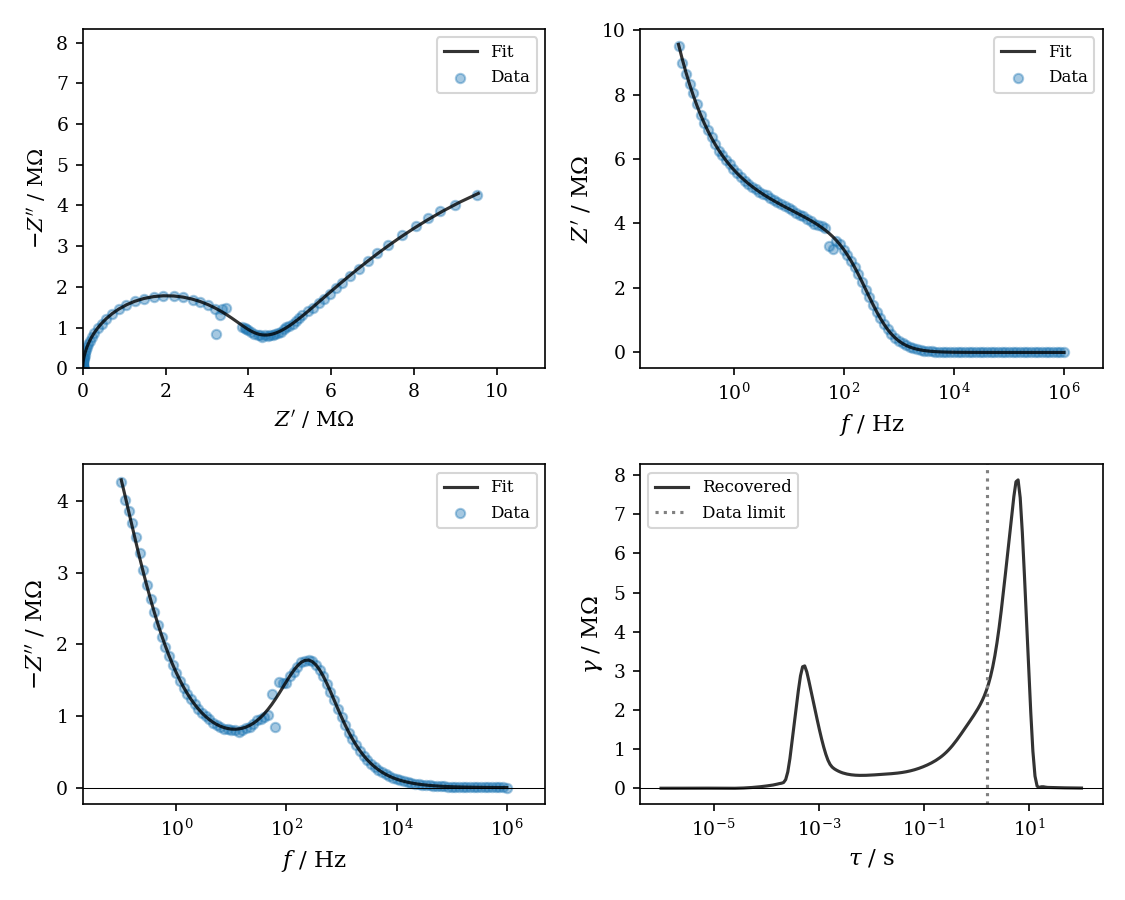

In [39]:
plot_drt_result(inv_map,Zdf)

<IPython.core.display.Javascript object>


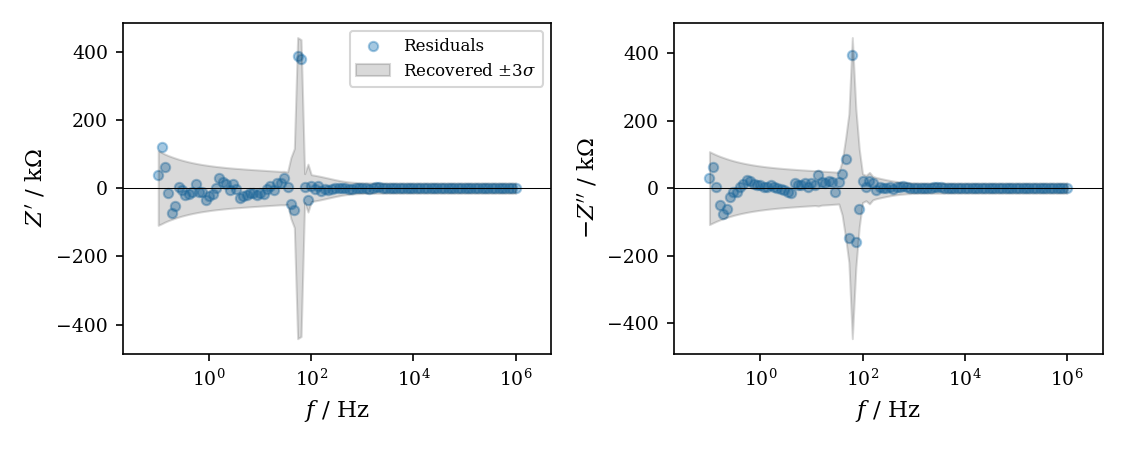

In [22]:
plot_resid(inv_map,Zdf)

The MAP fit produces a very similar DRT and error structure to the HMC result.

The values of `sigma_out` for the MAP optimization can be found in the `_opt_result` attribute.

<IPython.core.display.Javascript object>


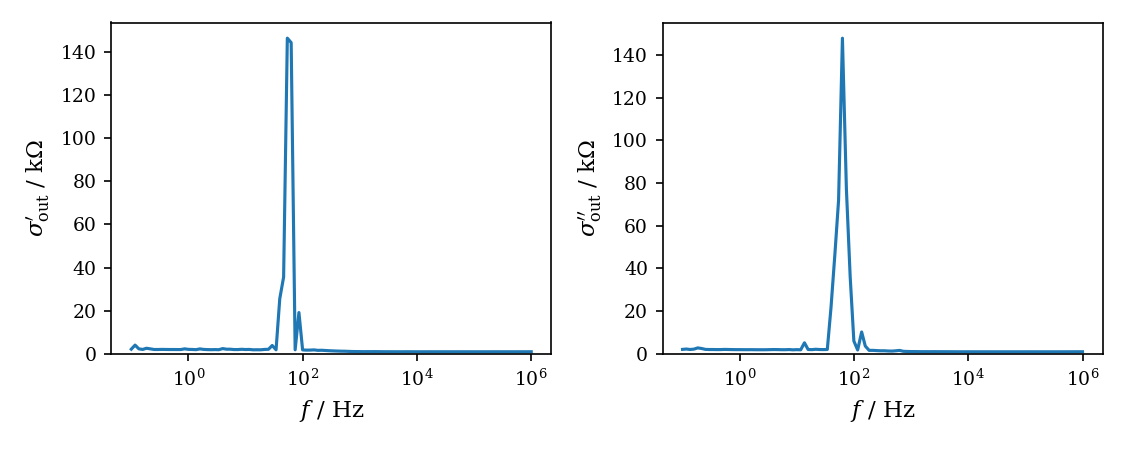

In [25]:
fig,axes = plt.subplots(1,2,figsize=(7.5,3),sharex=True)

# get sigma_out
sigma_out = inv_map._opt_result['sigma_out']
sigma_re = sigma_out[:len(freq)]*inv_map._Z_scale
sigma_im = sigma_out[len(freq):]*inv_map._Z_scale

axes[0].plot(freq,sigma_re/1e3)
axes[1].plot(freq,sigma_im/1e3)

for ax in axes:
    ax.set_xscale('log')
    ax.set_xlabel('$f$ / Hz')
    
axes[0].set_ylabel('$\sigma_{\mathrm{out}}^\prime$ / k$\Omega$')
axes[1].set_ylabel('$\sigma_{\mathrm{out}}^{\prime\prime}$ / k$\Omega$')

for ax in axes:
    ax.set_ylim(0,ax.get_ylim()[1])
    
fig.tight_layout()

A nice feature of the MAP optimization is that it tends to drive values of `sigma_out` for uncontaminated data points much closer to zero than HMC sampling, avoiding the slight inflation of the global error scale observed for HMC sampling.

# 4. Extrapolate the impedance

For an experimental dataset, it can be useful to extrapolate the impedance for visualization and estimation of the polarization resistance.

<IPython.core.display.Javascript object>


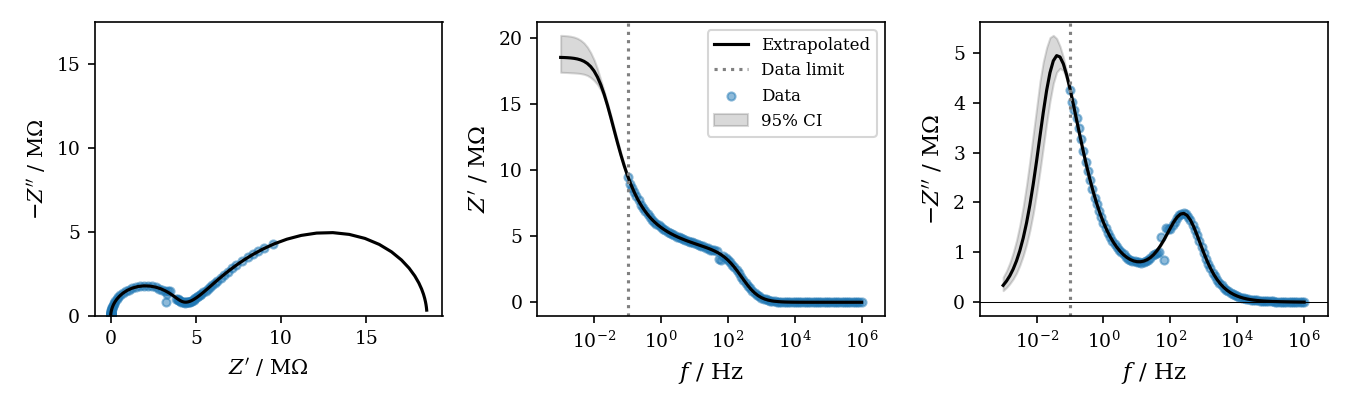

Predicted Rp: 18.56 M ohms
Rp 2.5 percentile: 17.43 M ohms
Rp 97.5 percentile: 20.23 M ohms


In [56]:
"Extrapolate the impedance using the HMC fit"
freq_full = np.logspace(6,-3,91)
Z_extrap = inv_hmc.predict_Z(freq_full)
df_extrap = gt.construct_eis_df(freq_full,Z_extrap)

# Calculate CIs for real and imag impedance
Z_lo = inv_hmc.predict_Z(freq_full,percentile=2.5)
Z_hi = inv_hmc.predict_Z(freq_full,percentile=97.5)

fig,axes = plt.subplots(1,3,figsize=(9,2.75))

# plot data
gt.plot_full_eis(Zdf,label='Data',axes=axes,bode_cols=['Zreal','Zimag'],s=15,alpha=0.5)
# plot mean predicted impedance
gt.plot_full_eis(df_extrap,label='Extrapolated',plot_func='plot',axes=axes,bode_cols=['Zreal','Zimag'],c='k')

# plot CIs on Bode plots
axes[1].fill_between(freq_full,Z_lo.real/1e6,Z_hi.real/1e6,color='k',alpha=0.15,label='95% CI')
axes[2].fill_between(freq_full,-Z_lo.imag/1e6,-Z_hi.imag/1e6,color='k',alpha=0.15)

for ax in [axes[0],axes[2]]:
    # mark zero line
    ax.axhline(0,c='k',lw=0.5)
for ax in axes[1:]:
    # plot data limits
    ax.axvline(Zdf['Freq'].min(),ls=':',c='gray',label='Data limit')
#     ax.axvline(Zdf['Freq'].max(),ls=':',c='gray')
    
axes[0].get_legend().remove()
axes[1].legend()

print('Predicted Rp: {:.2f} M ohms'.format(inv_hmc.predict_Rp()/1e6))
print('Rp 2.5 percentile: {:.2f} M ohms'.format(inv_hmc.predict_Rp(percentile=2.5)/1e6))
print('Rp 97.5 percentile: {:.2f} M ohms'.format(inv_hmc.predict_Rp(percentile=97.5)/1e6))

<IPython.core.display.Javascript object>


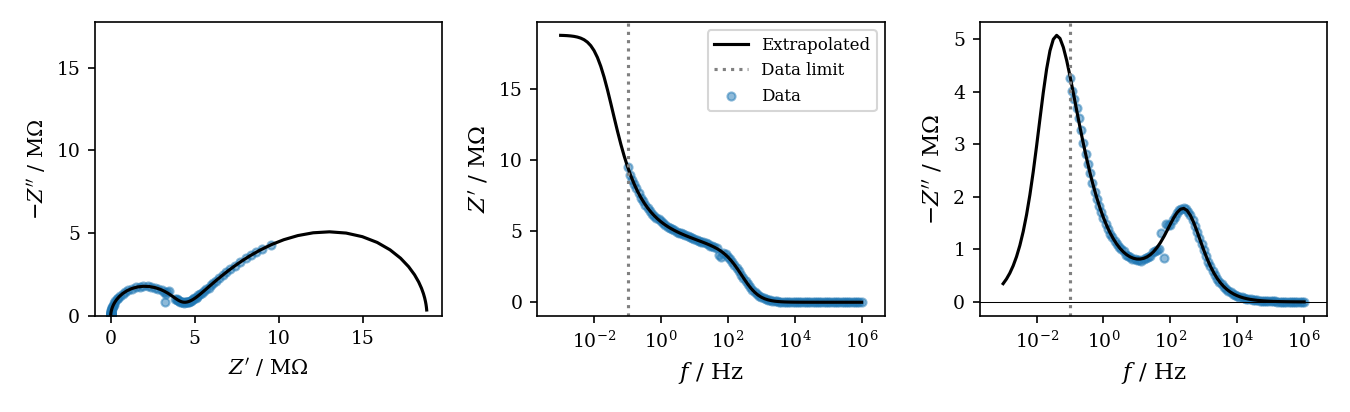

Predicted Rp: 18.83 M ohms


In [53]:
"Extrapolate the impedance using the MAP fit"
freq_full = np.logspace(6,-3,91)
Z_extrap = inv_map.predict_Z(freq_full)
df_extrap = gt.construct_eis_df(freq_full,Z_extrap)

fig,axes = plt.subplots(1,3,figsize=(9,2.75))

# plot data
gt.plot_full_eis(Zdf,label='Data',axes=axes,bode_cols=['Zreal','Zimag'],s=15,alpha=0.5)
# plot mean predicted impedance
gt.plot_full_eis(df_extrap,label='Extrapolated',plot_func='plot',axes=axes,bode_cols=['Zreal','Zimag'],c='k')

for ax in [axes[0],axes[2]]:
    # mark zero line
    ax.axhline(0,c='k',lw=0.5)
for ax in axes[1:]:
    # plot data limits
    ax.axvline(Zdf['Freq'].min(),ls=':',c='gray',label='Data limit')
#     ax.axvline(Zdf['Freq'].max(),ls=':',c='gray')
    
axes[0].get_legend().remove()
axes[1].legend()

print('Predicted Rp: {:.2f} M ohms'.format(inv_map.predict_Rp()/1e6))

The HMC and MAP results are in good agreement for the extrapolated impedance and predicted polarization resistance.

We can also visualize the HMC impedance distribution in the Nyquist representation using the method described in the extrapolation tutorial.

<IPython.core.display.Javascript object>


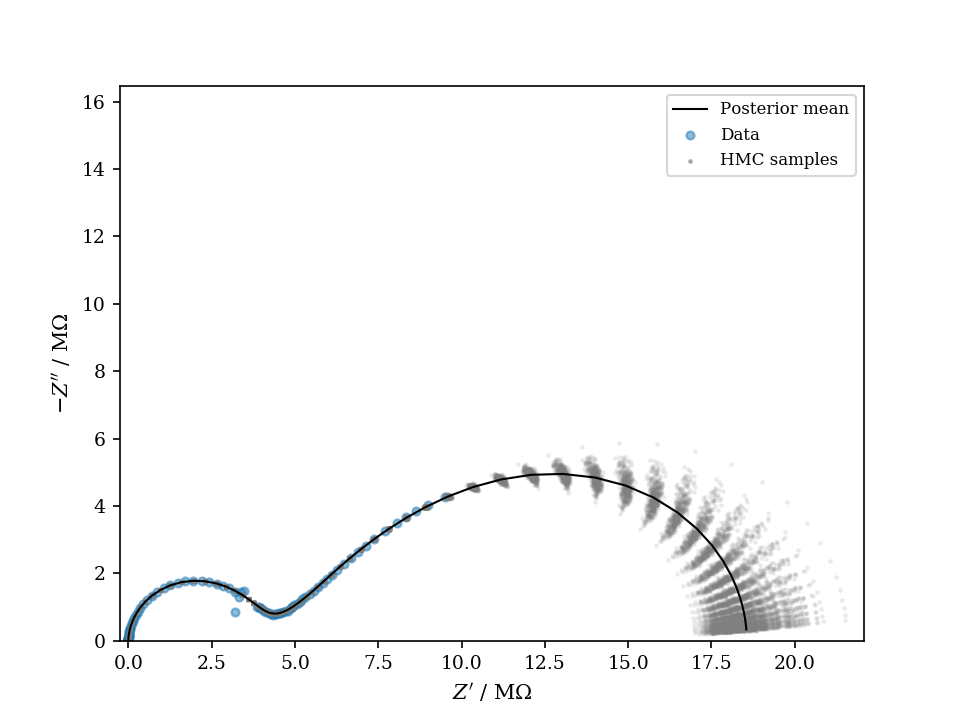

Number of samples: 400


In [47]:
# use the HMC samples to calculate Z samples
Z_pred_matrix = inv_hmc.predict_Z_distribution(freq_full)
# predict posterior mean
Z_pred_mean = inv_hmc.predict_Z(freq_full)
df_mean = gt.construct_eis_df(freq_full,Z_pred_mean)

fig,ax = plt.subplots()

# plot the data
gt.plot_nyquist(Zdf,label='Data',ax=ax,s=15,alpha=0.5,eq_xy=False)
# plot the posterior mean predicted impedance
gt.plot_nyquist(df_mean,plot_func='plot',label='Posterior mean',ax=ax,lw=1,c='k',eq_xy=False)

# each row of Z_pred_matrix is a sample. Plot each sample
print('Number of samples: {}'.format(Z_pred_matrix.shape[0]))
for i,Zp in enumerate(Z_pred_matrix):
    df = gt.construct_eis_df(freq_full,Zp)
    if i==0:
        label='HMC samples'
        # Make first sample darker for legend visibility
        alpha=0.5
    else:
        label=''
        alpha=0.1
    gt.plot_nyquist(df,ax=ax,s=2,alpha=alpha,c='gray',label=label)
    
ax.set_xlim(-0.25,ax.get_xlim()[1])
ax.legend()

The Nyquist plot shows the significant uncertainty in the low-frequency impedance, which arises as a result of the data truncation.